In [1]:
!pip install -q transformers datasets evaluate


In [2]:
!pip install --upgrade transformers



In [3]:
%env CUDA_VISIBLE_DEVICES

UsageError: Environment does not have key: CUDA_VISIBLE_DEVICES


In [1]:
%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
%env CUDA_VISIBLE_DEVICES

'7'

In [1]:
import os
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from structures.dataset_structure import COCOSegmentationDataset
from utils.data_preprocessor_utils import *
from config.config import get_mean_stds
from utils.visualize_utils import *
from tqdm import tqdm

In [3]:
def calculate_mean_std_dataloader(data_loader):
    # Initialize variables to accumulate sums
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    # Loop over the dataset to calculate the sum and squared sum
    for idx,batch in enumerate(tqdm(data_loader,desc=f"Calculating mean and std")):
        images, _ = batch
        batch_samples = images.size(0)  # Batch size
        images = images.view(batch_samples, 3, -1)  # Flatten the height and width
        mean += images.mean(dim=2).sum(dim=0)
        std += images.std(dim=2).sum(dim=0)
        total_images += batch_samples

    # Calculate the mean and std for the entire dataset
    mean /= total_images
    std /= total_images

    return mean,std

In [4]:
# Car_damages_dataset, Car_parts_dataset
dataset = "Car_damages_dataset"

if(dataset == "Car_damages_dataset"):
    coco_path = "coco_damage_annotations.json"
elif(dataset == "Car_parts_dataset"):
    coco_path = "coco_parts_annotations.json"

In [5]:
datadir = "./data/car-parts-and-car-damages/"

car_dir = os.path.join(datadir,dataset)
car_imgs = os.path.join(car_dir,"split_dataset")
car_anns = os.path.join(car_dir,"split_annotations")

In [6]:
car_id_to_color = get_colormapping(os.path.join(car_dir,coco_path),car_dir+"/meta.json")
car_id_to_color

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


{3: '#13A4C9',
 2: '#A6FF47',
 6: '#B42D38',
 8: '#E19660',
 1: '#903C59',
 7: '#A7741B',
 4: '#B40E13',
 5: '#73C2CE'}

In [7]:
is_normalize_image=True
ds_transform = dataset

mean,std = get_mean_stds(ds_transform)
# Create dataset
train_car_dataset = get_dataset(car_imgs,car_anns,is_train=True,dataset=ds_transform)
val_car_dataset = get_dataset(car_imgs,car_anns,dataset=ds_transform)


root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/train.json
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
root  ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/val
ann_file  ./data/car-parts-and-car-damages/Car_damages_dataset/split_annotations/val.json
loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [8]:
# Check an example
image, mask = train_car_dataset[50]
print(image.shape, mask.shape,train_car_dataset.img_path)  # Tensor dimensions

torch.Size([3, 640, 640]) torch.Size([1, 640, 640]) ./data/car-parts-and-car-damages/Car_damages_dataset/split_dataset/train/Car damages 1217.jpg


In [9]:
# with open('./mask.txt', 'w') as f:
#     for m in mask.numpy()[0]:
#         f.write("%s\n" % m)

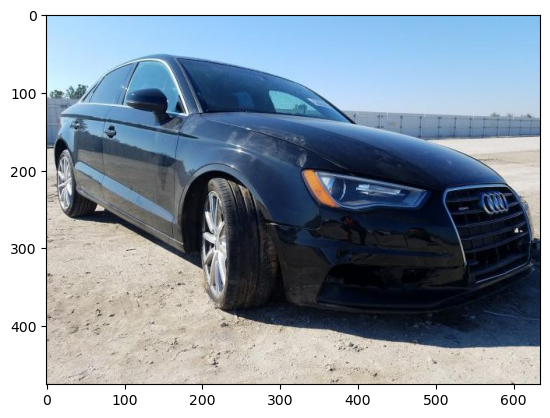

In [10]:
plt.imshow(Image.open(train_car_dataset.img_path))

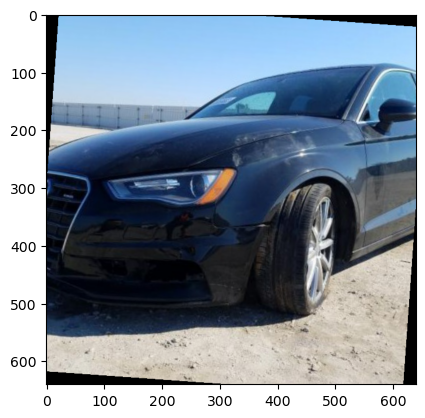

In [11]:
if(is_normalize_image):
    plt.imshow(unnormalize_image(image.transpose(0,-1).transpose(0,1).numpy(),mean=mean,std=std))
else:
    plt.imshow(image.transpose(0,-1).transpose(0,1).numpy())

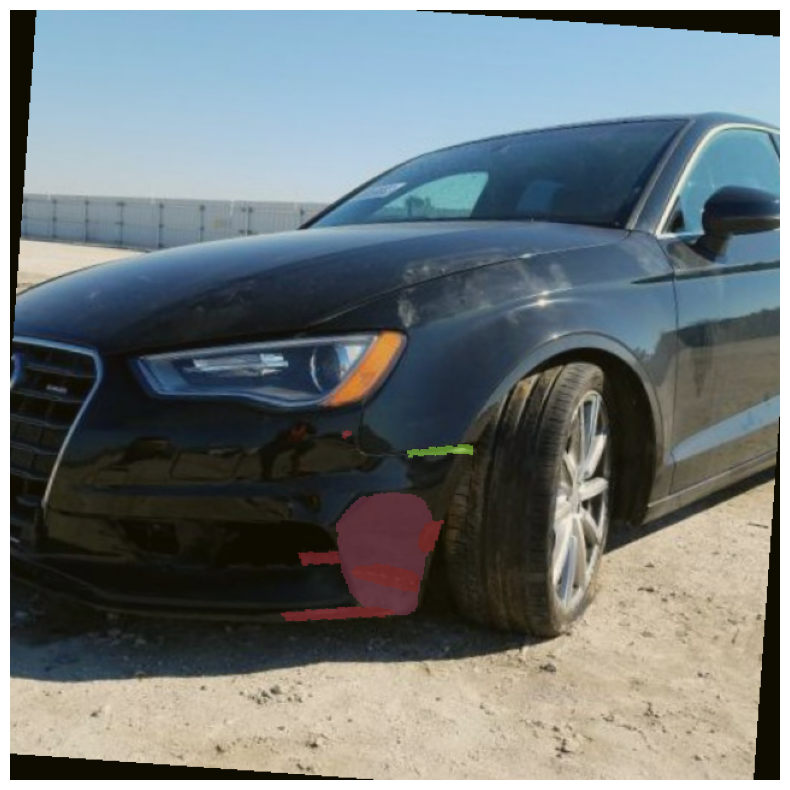

In [12]:
overlayed_image = overlay_colored_mask(image.transpose(0,-1).transpose(0,1).numpy(), mask[0].numpy(), car_id_to_color, alpha=0.5,is_normalize_image=is_normalize_image)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [13]:
from torch.utils.data import DataLoader

# Create DataLoader
tr_cd_dataloader = DataLoader(train_car_dataset, batch_size=2, shuffle=True)
val_cd_dataloader = DataLoader(val_car_dataset, batch_size=2)

In [14]:
# Change transforms correctly without any augmentations to get correct picture
# calculate_mean_std_dataloader(tr_cd_dataloader)

#### CAR Damage dataset train set: Mean - (tensor([0.4693, 0.4597, 0.4667]), Standard deviation - tensor([0.2515, 0.2506, 0.2500]))

In [15]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
from car_segmentation import get_segformermodel,get_model_from_path,evaluate_model
from structures.heirarchical_seg_model import Hierarchical_SegModel,Fusion_SegModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2025-01-04 22:08:56.345459: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-04 22:08:57.298493: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2025-01-04 22:08:57.298598: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work

In [17]:
# None, 'hierarchical' , 'fusion'
model_type = 'fusion'

# pretrained_model_name = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
pretrained_model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
start_net_path="./checkpoints/high_aug_tnorm_/Car_damages_dataset/fusi/dice_0.5/nvidia_segformer-b5-finetuned-ade-640-640_ep_26.pt"

superseg_model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
super_segmodel_path = "./checkpoints/Car_parts_dataset/nvidia_segformer-b3-finetuned-cityscapes-1024-1024_ep_90.pt"
if(model_type is None):
    model = get_segformermodel(len(car_id_to_color),pretrained_model_name)
elif(model_type == 'hierarchical' or model_type == 'fusion'):
    superseg_ds = "Car_parts_dataset"
    superseg_dir = os.path.join(datadir,superseg_ds)
    superseg_id_to_color = get_colormapping(os.path.join(superseg_dir,get_cocopath(superseg_ds)),superseg_dir+"/meta.json")
    super_segmodel = get_segformermodel(len(superseg_id_to_color),superseg_model_name)
    super_segmodel,_ = get_model_from_path(super_segmodel,super_segmodel_path)
    if(model_type=='hierarchical'):
        model = Hierarchical_SegModel(super_segmodel,len(superseg_id_to_color)+1,len(car_id_to_color)+1,pretrained_model_name)
    elif(model_type == 'fusion'):
        model = Fusion_SegModel(super_segmodel,len(superseg_id_to_color)+1,len(car_id_to_color)+1,pretrained_model_name)
model,_ = get_model_from_path(model,start_net_path)


loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-cityscapes-1024-1024 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([19, 768, 1, 1]) in the checkpoint and torch.Size([22, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([19]) in the checkpoint and torch.Size([22]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from ./checkpoints/Car_parts_dataset/nvidia_segformer-b3-finetuned-cityscapes-1024-1024_ep_90.pt


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b5-finetuned-ade-640-640 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([9, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([9]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded from ./checkpoints/high_aug_tnorm_/Car_damages_dataset/fusi/dice_0.5/nvidia_segformer-b5-finetuned-ade-640-640_ep_26.pt


In [18]:
evaluate_model(model.cuda(),len(car_id_to_color),val_cd_dataloader)

Evaluating:   0%|          | 0/82 [00:00<?, ?it/s]/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/datasets/features/image.py:334: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Evaluating:   1%|          | 1/82 [00:01<01:39,  1.23s/it]/home/akshay/.conda/envs/research-work-DAG-DNN/

Validation loss: 0.29691996320900393 mean_iou :0.5207183978762112, mean_accuracy :0.7174835731513344 val_pixel_accuracy: 0.9331024914253045 val_dice_coeff : 0.5206987785130013


(0.29691996320900393,
 0.5207183978762112,
 0.7174835731513344,
 0.9331024914253045,
 0.5206987785130013)

In [19]:
evaluate_model(model.cuda(),len(car_id_to_color),tr_cd_dataloader)

Evaluating:   0%|          | 0/326 [00:00<?, ?it/s]/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/datasets/features/image.py:334: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/home/akshay/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
Evaluating:   0%|          | 1/326 [00:00<02:26,  2.22it/s]/home/akshay/.conda/envs/research-work-DAG-DN

Validation loss: 0.07926322692330995 mean_iou :0.5409067726363012, mean_accuracy :0.5789596226540469 val_pixel_accuracy: 0.9748494004325634 val_dice_coeff : 0.7066051903312192


(0.07926322692330995,
 0.5409067726363012,
 0.5789596226540469,
 0.9748494004325634,
 0.7066051903312192)

In [20]:
iter_train = iter(val_cd_dataloader)

In [51]:
img,msk = next(iter_train)
msk=msk.squeeze(1)
img.size(),msk.size()

(torch.Size([2, 3, 640, 640]), torch.Size([2, 640, 640]))

In [52]:
import torch.nn.functional as F
model = model.cpu()
outputs = model(img,msk)
logits = outputs.logits
with torch.no_grad():
    upsampled_logits = F.interpolate(logits, size=msk.shape[-2:], mode="bilinear", align_corners=False)
    predicted = upsampled_logits.argmax(dim=1)


In [53]:
predicted.size(),msk.size(),upsampled_logits.size(),logits.size(),img.size()

(torch.Size([2, 640, 640]),
 torch.Size([2, 640, 640]),
 torch.Size([2, 9, 640, 640]),
 torch.Size([2, 9, 160, 160]),
 torch.Size([2, 3, 640, 640]))

In [58]:
ind=0

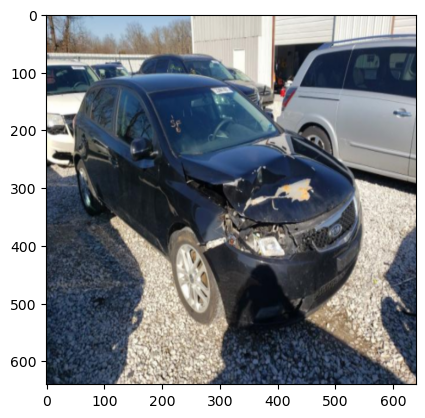

In [59]:
if(is_normalize_image):
    plt.imshow(unnormalize_image(img[ind].transpose(0,-1).transpose(0,1).numpy(),mean=mean,std=std))
else:
    plt.imshow(img[ind].transpose(0,-1).transpose(0,1).numpy())

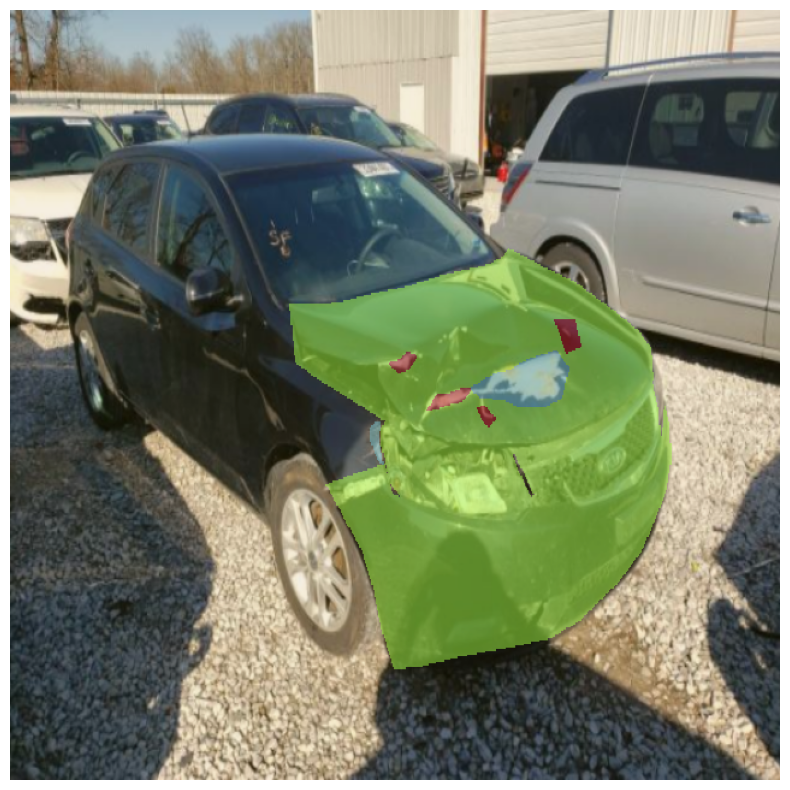

In [60]:
overlayed_image = overlay_colored_mask(img[ind].transpose(0,-1).transpose(0,1).numpy(), msk[ind].numpy(), car_id_to_color, alpha=0.5,is_normalize_image=is_normalize_image)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

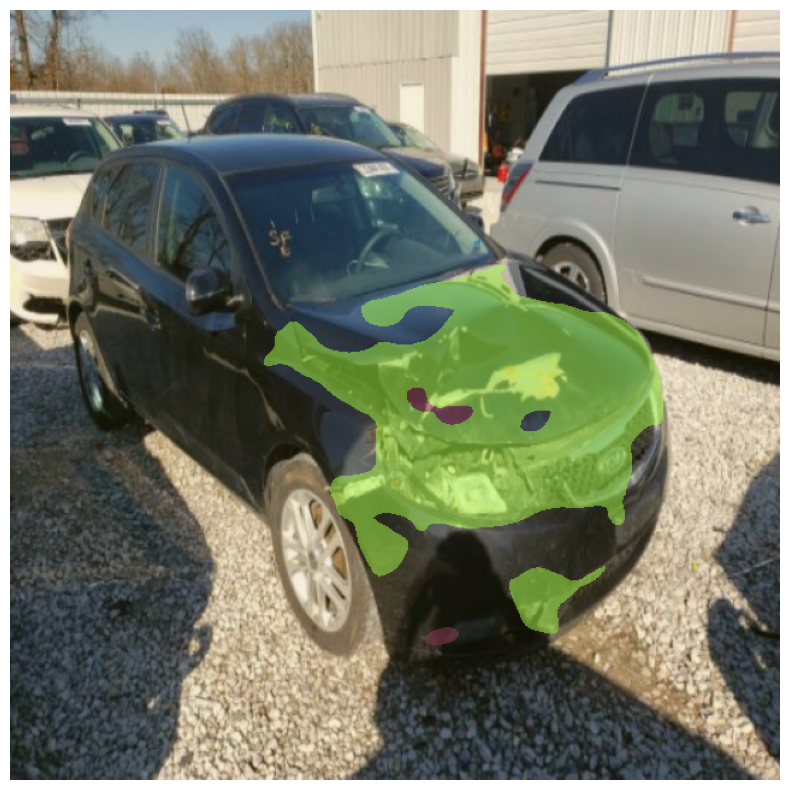

: 

In [ ]:
overlayed_image = overlay_colored_mask(img[ind].transpose(0,-1).transpose(0,1).numpy(), predicted[ind].numpy(), car_id_to_color, alpha=0.5,is_normalize_image=is_normalize_image)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(overlayed_image)
plt.axis('off')
plt.show()

In [93]:
with open('./mask.txt', 'w') as f:
    for m in msk.numpy()[0]:
        f.write("%s\n" % m)

with open('./pred.txt', 'w') as f:
    for m in predicted.numpy()[0]:
        f.write("%s\n" % m)

2024-12-30 01:22:32.797693: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797803: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/site-packages/cv2/../../lib64:
2024-12-30 01:22:32.797814: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
/home/akshay/.conda/envs/research-work-DAG-DNN/lib/python3.7/

inputs  torch.Size([1, 3, 1024, 1024])
logits  torch.Size([1, 19, 256, 256])


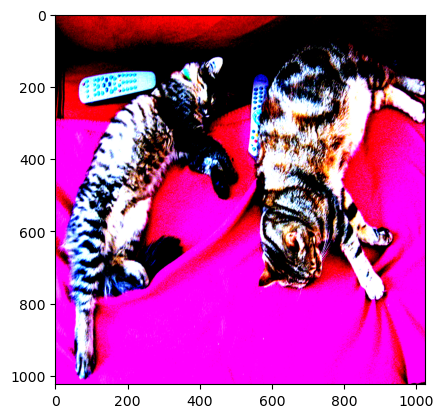

In [18]:
# from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
# from PIL import Image
# import requests

# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
# model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)
# inputs = feature_extractor(images=image, return_tensors="pt")
# print("inputs ",inputs["pixel_values"].shape)
# plt.imshow(inputs["pixel_values"][0].transpose(0,-1).transpose(0,1).numpy())
# outputs = model(**inputs)
# logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
# print("logits ",logits.size())